In [ ]:
import itertools
from IPython.display import clear_output

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from skimage import io, transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import pathlib


import random
import time
import datetime
import sys

import torch
import numpy as np

import os
import random
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/My\ Drive/monet2photo.zip -d data

In [ ]:
!ls data/monet2photo

testA  testB  trainA  trainB


In [ ]:
def imshow_(image: torch.Tensor):
    """ image rendering function"""
    img = np.transpose(vutils.make_grid(image.detach(), normalize=True).cpu().numpy(), (1, 2, 0))
    plt.imshow(img)

In [ ]:
class utils():
    def __init__(self):
        pass

    @staticmethod
    def weights_init_normal(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            torch.nn.init.normal(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant(m.bias.data, 0.0)
    
    @staticmethod
    def copy_(data):
        max_size = 50
        array = []
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(array) < max_size:
                array.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, max_size-1)
                    to_return.append(array[i].clone())
                    array[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

In [ ]:
class Storage():
    def __init__(self, arg):
        self.arg = arg
    

    def __getattr__(self, key):
        return self.arg[key]

In [ ]:
storage = Storage({
    'lr': 0.00005,
    'n_epoch': 1000,
    'size_image': 512,
    'device': torch.device('cuda'),
    'batch_size': 1,
    'relevance_identify': 6,
    'relevance_cycle': 10,
})

In [ ]:
class MyDataset(Dataset):

    def __init__(self, files, root_dir, transform=None):
        self.files = files
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = io.imread(self.files[idx])

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(3, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, 3, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(3, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [ ]:
TRAIN_DIR_A = Path('data/monet2photo/trainA')
TRAIN_DIR_B = Path('data/monet2photo/trainB')

list_name_a = sorted(list(TRAIN_DIR_A.rglob('*.jpg')))
list_name_b = sorted(list(TRAIN_DIR_B.rglob('*.jpg')))

In [ ]:
transform = transforms.Compose([                  
            transforms.ToPILImage(),           
            transforms.Resize((storage.size_image, storage.size_image)),                              
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
dataset_a = MyDataset(list_name_a, 'data/dataset/A', transform)
dataset_b = MyDataset(list_name_b, 'data/dataset/B', transform)

dataloader_a = DataLoader(dataset_a, batch_size=storage.batch_size, shuffle=True)
dataloader_b = DataLoader(dataset_b, batch_size=storage.batch_size, shuffle=True)
# содание даталоадеров

In [ ]:
from torchvision.models import resnet18
from torchsummary import summary

In [ ]:
dis_a = Discriminator().cuda()
dis_b = Discriminator().cuda()
gen_ab = Generator().cuda()
gen_ba = Generator().cuda()

dis_a.apply(utils.weights_init_normal)
dis_b.apply(utils.weights_init_normal)
gen_ab.apply(utils.weights_init_normal)
gen_ba.apply(utils.weights_init_normal);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  if __name__ == '__main__':


In [ ]:
dis_a.load_state_dict(torch.load('/content/drive/My Drive/dis_a80.pth'))
dis_b.load_state_dict(torch.load('/content/drive/My Drive/dis_b80.pth'))
gen_ab.load_state_dict(torch.load('/content/drive/My Drive/gen_ab80.pth'))
gen_ba.load_state_dict(torch.load('/content/drive/My Drive/gen_ba80.pth'))

<All keys matched successfully>

In [ ]:
opt_g = torch.optim.Adam(itertools.chain(gen_ab.parameters(), gen_ba.parameters()),
                                lr=storage.lr, betas=(0.5, 0.999))
opt_d_b = torch.optim.Adam(dis_b.parameters(), lr=storage.lr, betas=(0.5, 0.999))
opt_d_a = torch.optim.Adam(dis_a.parameters(), lr=storage.lr, betas=(0.5, 0.999))

In [ ]:
GAN_loss_fn = torch.nn.MSELoss()
cycle_and_identity_loss_fn = torch.nn.L1Loss()

In [ ]:
sched_g = torch.optim.lr_scheduler.StepLR(opt_g, 200, 0.1)
sched_d_ba = torch.optim.lr_scheduler.StepLR(opt_d_b, 200, 0.1)
sched_d_ab = torch.optim.lr_scheduler.StepLR(opt_d_a, 200, 0.1)

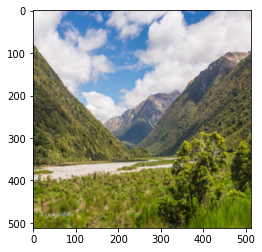

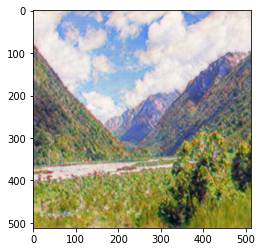

In [ ]:
for i in dataloader_b:
    imshow_(i)
    plt.show()
    imshow_(gen_ba(i.cuda()))
    break

Изначально я учил 130 эпох с шагом 0.0002 на картинках 256х256.
Потом 23 эпохи с шагом 0.0005 на картинках 512х512

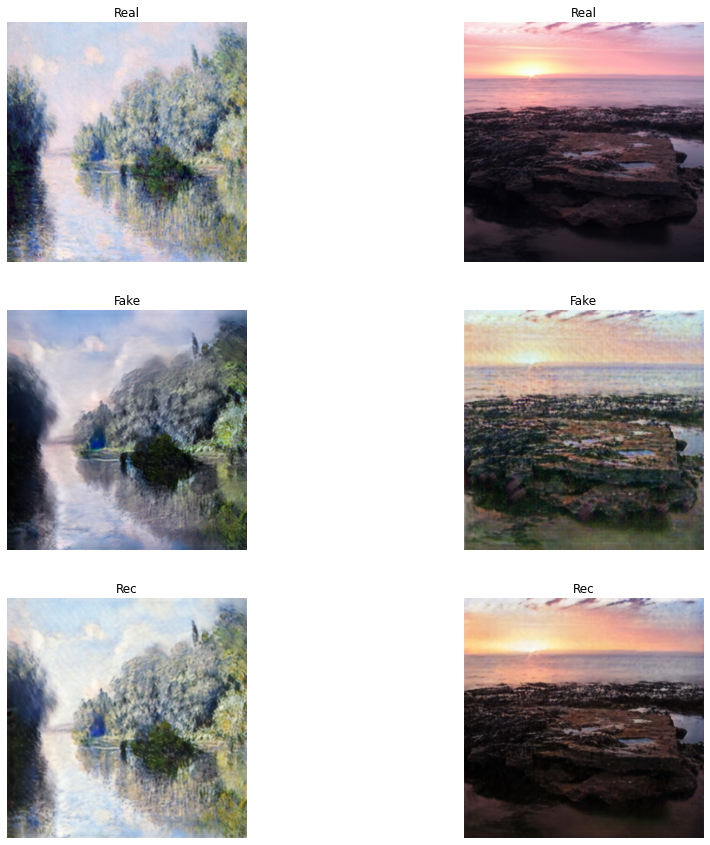

Epoch: 23 	 num_iter: 0 	 G_loss: 5.500554084777832 	 D_loss: 0.39735399186611176
Epoch: 23 	 num_iter: 10 	 G_loss: 5.127292633056641 	 D_loss: 0.3547002822160721
Epoch: 23 	 num_iter: 20 	 G_loss: 4.775240898132324 	 D_loss: 0.2236381284892559
Epoch: 23 	 num_iter: 30 	 G_loss: 6.060397624969482 	 D_loss: 0.660402700304985
Epoch: 23 	 num_iter: 40 	 G_loss: 6.448462963104248 	 D_loss: 0.1458670198917389
Epoch: 23 	 num_iter: 50 	 G_loss: 4.326433181762695 	 D_loss: 0.8904937505722046
Epoch: 23 	 num_iter: 60 	 G_loss: 6.2956109046936035 	 D_loss: 0.15741697512567043
Epoch: 23 	 num_iter: 70 	 G_loss: 6.779110908508301 	 D_loss: 0.2597932144999504
Epoch: 23 	 num_iter: 80 	 G_loss: 5.864455699920654 	 D_loss: 0.29854296147823334
Epoch: 23 	 num_iter: 90 	 G_loss: 5.739295959472656 	 D_loss: 0.32377202063798904
Epoch: 23 	 num_iter: 100 	 G_loss: 6.867908954620361 	 D_loss: 0.34206478483974934
Epoch: 23 	 num_iter: 110 	 G_loss: 8.633478164672852 	 D_loss: 0.5595912411808968
Epoch: 23 

KeyboardInterrupt: ignored

In [ ]:
for epoch in range(storage.n_epoch):
    for i, (real_a, real_b) in enumerate(zip(dataloader_a, dataloader_b)):
        real_a, real_b = real_a.to(storage.device), real_b.to(storage.device)

        """ Generator"""
        opt_g.zero_grad()

        # 1 Identify loss
        same_a = gen_ba(real_a)
        same_b = gen_ab(real_b)
        identify_loss = (cycle_and_identity_loss_fn(same_b, real_b) + cycle_and_identity_loss_fn(same_a, real_b)) * storage.relevance_identify

        # 2 Loss
        fake_a = gen_ba(real_b)
        fake_b = gen_ab(real_a)

        output_d_a = dis_a(fake_a)
        output_d_b = dis_b(fake_b)

        label = torch.full((real_a.size(0),), 1, device=storage.device)
        
        d_a_loss = GAN_loss_fn(output_d_a, label)
        d_b_loss = GAN_loss_fn(output_d_b, label)
        
        # 3 Cycle loss
        rec_a = gen_ba(fake_b)
        rec_b = gen_ab(fake_a)

        cycle_loss_a = cycle_and_identity_loss_fn(rec_a, real_a) * storage.relevance_cycle
        cycle_loss_b = cycle_and_identity_loss_fn(rec_b, real_b) * storage.relevance_cycle

        # 4 Backward
        loss_gen = identify_loss + d_a_loss + d_b_loss + cycle_loss_a + cycle_loss_b
        loss_gen.backward()

        opt_g.step()
        """ Discriminator"""
        opt_d_a.zero_grad()
        opt_d_b.zero_grad()

        # 1 
        output_d_a = dis_a(real_a)
        output_d_b = dis_b(real_b)

        label = torch.full((output_d_a.size(0),), 1, device=storage.device)
        loss_d_a = GAN_loss_fn(output_d_a, label)
        loss_d_b = GAN_loss_fn(output_d_b, label)

        # 2 
        fake_a = utils.copy_(fake_a)
        fake_b = utils.copy_(fake_b)

        output_d_a = dis_a(fake_a.detach())
        output_d_b = dis_b(fake_b.detach())

        label = torch.full((output_d_a.size(0),), 0, device=storage.device)
        loss_d_a_f = GAN_loss_fn(output_d_a, label)
        loss_d_b_f = GAN_loss_fn(output_d_b, label)

        # 3 
        loss_dis_a = loss_d_a_f * 0.6 + loss_d_a * 0.7
        loss_dis_b = loss_d_b_f * 0.6 + loss_d_b * 0.7

        loss_dis_a.backward()
        loss_dis_b.backward()

        opt_d_a.step()
        opt_d_b.step()

        if i % 10 == 0: print('Epoch: {} \t num_iter: {} \t G_loss: {} \t D_loss: {}'.format(epoch, i, loss_gen.item(), loss_dis_a.item() + loss_dis_b.item()))

    clear_output(wait=True)
    sched_g.step()
    sched_d_ba.step()
    sched_d_ab.step()

    plt.figure(figsize=(15, 15))
    plt.subplot(3, 2, 1)
    imshow_(real_a[0])
    plt.title('Real')
    plt.axis('off')

    plt.subplot(3, 2, 3)
    imshow_(fake_b[0])
    plt.title('Fake')
    plt.axis('off')

    plt.subplot(3, 2, 5)
    imshow_(rec_a[0])
    plt.title('Rec')
    plt.axis('off')

    plt.subplot(3, 2, 2)
    imshow_(real_b[0])
    plt.title('Real')
    plt.axis('off')

    plt.subplot(3, 2, 4)
    imshow_(fake_a[0])
    plt.title('Fake')
    plt.axis('off')

    plt.subplot(3, 2, 6)
    imshow_(rec_b[0])
    plt.title('Rec')
    plt.axis('off')
    plt.show() 

    if epoch % 5 == 0:
        torch.save(gen_ab.state_dict(), '/content/drive/My Drive/gen_ab{}.pth'.format(epoch))
        torch.save(gen_ba.state_dict(), '/content/drive/My Drive/gen_ba{}.pth'.format(epoch))
        torch.save(dis_a.state_dict(), '/content/drive/My Drive/dis_a{}.pth'.format(epoch))
        torch.save(dis_b.state_dict(), '/content/drive/My Drive/dis_b{}.pth'.format(epoch))

In [ ]:
epoch = 23
torch.save(gen_ab.state_dict(), '/content/drive/My Drive/gen_ab{}.pth'.format(epoch))
torch.save(gen_ba.state_dict(), '/content/drive/My Drive/gen_ba{}.pth'.format(epoch))
torch.save(dis_a.state_dict(), '/content/drive/My Drive/dis_a{}.pth'.format(epoch))
torch.save(dis_b.state_dict(), '/content/drive/My Drive/dis_b{}.pth'.format(epoch))